In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
# STEP 1: Load and inspect data
import pandas as pd
import numpy as np

train_df = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nMissing values in train:")
print(train_df.isnull().sum())

# STEP 2: Initial cleaning (proper in-place operations)
# Create copies to avoid SettingWithCopy warnings
train_clean = train_df.copy()
test_clean = test_df.copy()

# Save test IDs before dropping
test_ids = test_clean['id'].copy()

# Drop ID columns safely
train_clean = train_clean.drop(columns=['id'])
test_clean = test_clean.drop(columns=['id'])

# Handle missing values using proper assignment
numeric_cols = train_clean.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('rainfall', errors='ignore')

# Calculate medians from training data first
col_medians = train_clean[numeric_cols].median()

# Fill missing values using .loc to avoid chained assignment
for col in numeric_cols:
    train_clean.loc[:, col] = train_clean[col].fillna(col_medians[col])
    test_clean.loc[:, col] = test_clean[col].fillna(col_medians[col])  # Use train stats

# STEP 3: Feature engineering (safe implementation)
def add_weather_features(df):
    df = df.copy()  # Avoid modifying original
    # Cyclical day encoding
    df['day_sin'] = np.sin(2 * np.pi * df['day']/365)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/365)
    
    # Meteorological features
    df['temp_range'] = df['maxtemp'] - df['mintemp']
    df['dewpoint_diff'] = df['temparature'] - df['dewpoint']
    df['humidity_cloud'] = df['humidity'] * df['cloud'] / 100
    
    # Pressure trends with proper shift handling
    df['pressure_change_24h'] = df['pressure'].diff()
    return df

# Apply feature engineering
train_final = add_weather_features(train_clean)
test_final = add_weather_features(test_clean)

# Handle first-row pressure change safely
train_final.loc[:, 'pressure_change_24h'] = train_final['pressure_change_24h'].fillna(0)
test_final.loc[:, 'pressure_change_24h'] = test_final['pressure_change_24h'].fillna(0)

# STEP 4: Prepare for train-val split
X = train_final.drop(columns=['rainfall'])
y = train_final['rainfall'].copy()

# Save fully processed test data
test_processed = test_final.copy()

Train shape: (2190, 13)
Test shape: (730, 12)

Missing values in train:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

# Stratified split (maintains class balance)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (1752, 17), Val: (438, 17)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_processed)

In [5]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    "XGBoost": XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.7,
        early_stopping_rounds=50,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        objective="binary",
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        reg_alpha=0.1,
        early_stopping_rounds=50,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        eval_metric="Logloss",
        early_stopping_rounds=50,
        verbose=0,
        random_state=42
    )
}

In [6]:
from sklearn.metrics import roc_auc_score, log_loss
from lightgbm import early_stopping, log_evaluation

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    try:
        # XGBoost and CatBoost
        if name in ["XGBoost", "CatBoost"]:
            model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_val_scaled, y_val)],
                verbose=10 if name == "XGBoost" else 0  # CatBoost uses silent/verbose param
            )
        
        # LightGBM needs special handling
        elif name == "LightGBM":
            model.fit(
                X_train_scaled, y_train,
                eval_set=[(X_val_scaled, y_val)],
                callbacks=[
                    early_stopping(50),
                    log_evaluation(10)  # Prints every 10 iterations
                ]
            )
            
        # Evaluation
        val_pred = model.predict_proba(X_val_scaled)[:, 1]
        print(f"\n{name} Performance:")
        print(f"ROC AUC: {roc_auc_score(y_val, val_pred):.4f}")
        print(f"Log Loss: {log_loss(y_val, val_pred):.4f}")
        
    except Exception as e:
        print(f"Error in {name}: {str(e)}")


Training XGBoost...
[0]	validation_0-logloss:0.54090
[10]	validation_0-logloss:0.40996
[20]	validation_0-logloss:0.35747
[30]	validation_0-logloss:0.32886
[40]	validation_0-logloss:0.31587
[50]	validation_0-logloss:0.30988
[60]	validation_0-logloss:0.30656
[70]	validation_0-logloss:0.30742
[80]	validation_0-logloss:0.30645
[90]	validation_0-logloss:0.30718
[100]	validation_0-logloss:0.30651
[110]	validation_0-logloss:0.30842
[111]	validation_0-logloss:0.30841

XGBoost Performance:
ROC AUC: 0.9118
Log Loss: 0.3059

Training LightGBM...
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2866
[LightGBM] [Info] Number of data points in the train set: 17

In [7]:
# Get base model predictions
xgb_pred = models["XGBoost"].predict_proba(X_val_scaled)[:, 1]
lgbm_pred = models["LightGBM"].predict_proba(X_val_scaled)[:, 1]
cat_pred = models["CatBoost"].predict_proba(X_val_scaled)[:, 1]

# Optimize weights (example: equal weighting)
ensemble_pred = 0.4*xgb_pred + 0.3*lgbm_pred + 0.3*cat_pred

print("\nEnsemble Performance:")
print(f"ROC AUC: {roc_auc_score(y_val, ensemble_pred):.4f}")
print(f"Log Loss: {log_loss(y_val, ensemble_pred):.4f}")


Ensemble Performance:
ROC AUC: 0.9166
Log Loss: 0.3026


In [8]:
# Get test predictions from all models
xgb_test = models["XGBoost"].predict_proba(test_scaled)[:, 1]
lgbm_test = models["LightGBM"].predict_proba(test_scaled)[:, 1]
cat_test = models["CatBoost"].predict_proba(test_scaled)[:, 1]

# Blend predictions
final_pred = 0.4*xgb_test + 0.3*lgbm_test + 0.3*cat_test

# Create submission
submission = pd.DataFrame({
    "id": test_ids,
    "rainfall": final_pred
})
submission.to_csv("rainfall_submission.csv", index=False)

In [9]:
# Quick check of your submission file
submission = pd.read_csv("rainfall_submission.csv")
print(submission.head())
print("\nSubmission stats:")
print(f"Mean rainfall probability: {submission['rainfall'].mean():.4f}")
print(f"Rain rate (% >0.5 threshold): {(submission['rainfall'] > 0.5).mean()*100:.2f}%")

     id  rainfall
0  2190  0.982497
1  2191  0.984074
2  2192  0.937526
3  2193  0.105678
4  2194  0.109057

Submission stats:
Mean rainfall probability: 0.7659
Rain rate (% >0.5 threshold): 79.45%


<Figure size 1000x600 with 0 Axes>

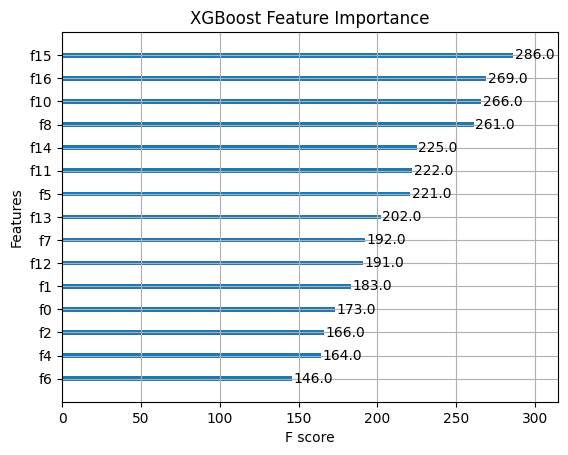

<Figure size 1000x600 with 0 Axes>

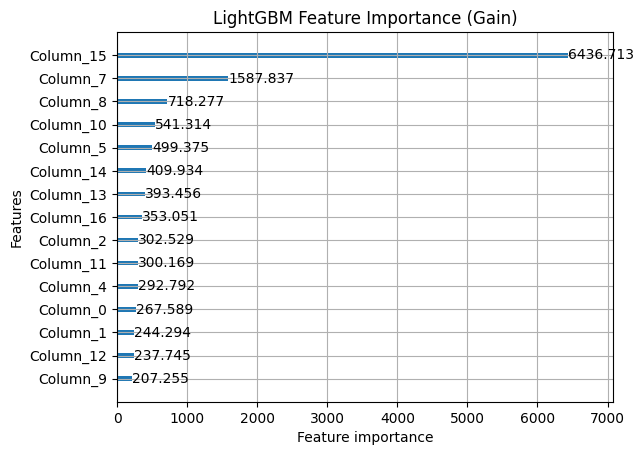

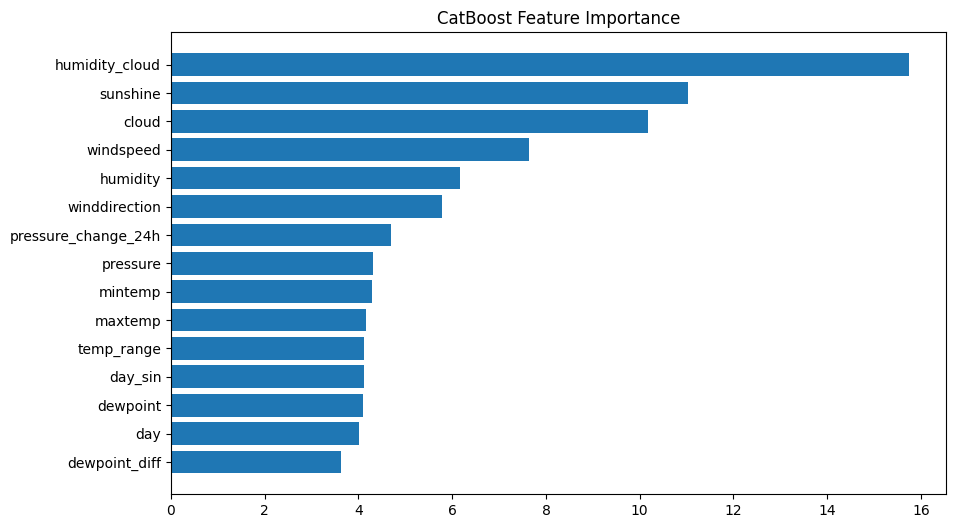

In [10]:
import matplotlib.pyplot as plt
from xgboost import plot_importance as xgb_plot_importance
from lightgbm import plot_importance as lgbm_plot_importance

# XGBoost feature importance
plt.figure(figsize=(10, 6))
xgb_plot_importance(models["XGBoost"], max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.show()

# LightGBM feature importance
plt.figure(figsize=(10, 6))
lgbm_plot_importance(models["LightGBM"], importance_type='gain', max_num_features=15)
plt.title("LightGBM Feature Importance (Gain)")
plt.show()

# CatBoost feature importance (requires different handling)
catboost_importances = models["CatBoost"].get_feature_importance()
sorted_idx = np.argsort(catboost_importances)[-15:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), catboost_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title("CatBoost Feature Importance")
plt.show()

In [11]:
# Get individual model predictions
xgb_preds = models["XGBoost"].predict_proba(X_val_scaled)[:, 1]
lgbm_preds = models["LightGBM"].predict_proba(X_val_scaled)[:, 1]
cat_preds = models["CatBoost"].predict_proba(X_val_scaled)[:, 1]

# Create weighted ensemble predictions
val_preds = 0.4*xgb_preds + 0.3*lgbm_preds + 0.3*cat_preds

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       108
           1       0.90      0.93      0.92       330

    accuracy                           0.87       438
   macro avg       0.83      0.80      0.82       438
weighted avg       0.87      0.87      0.87       438



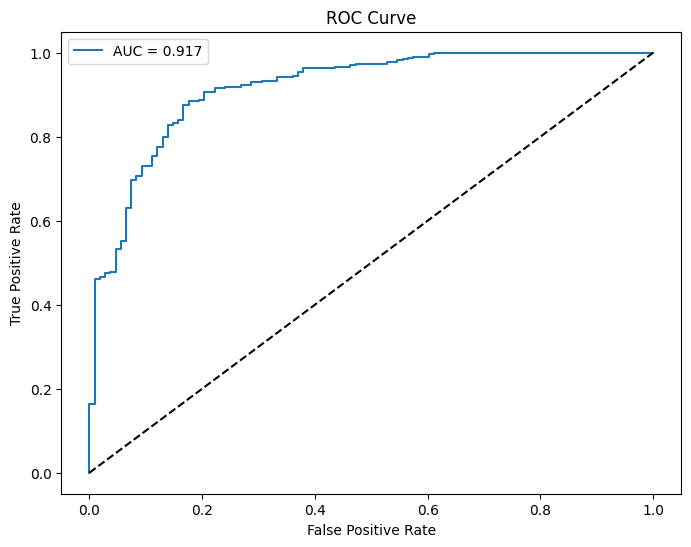

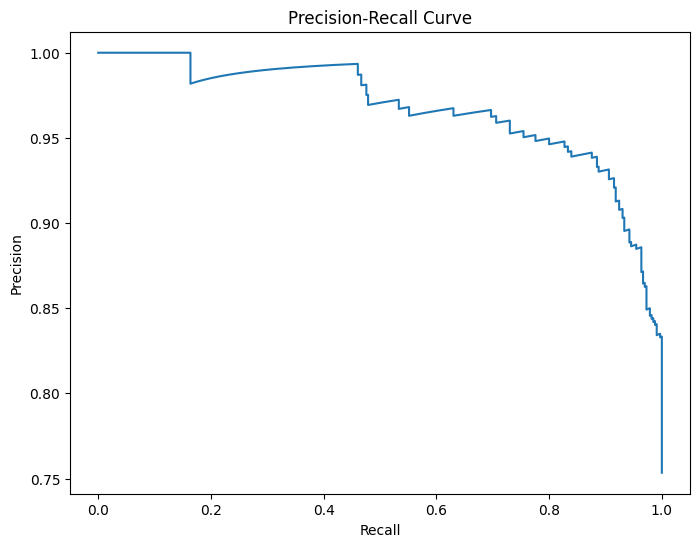

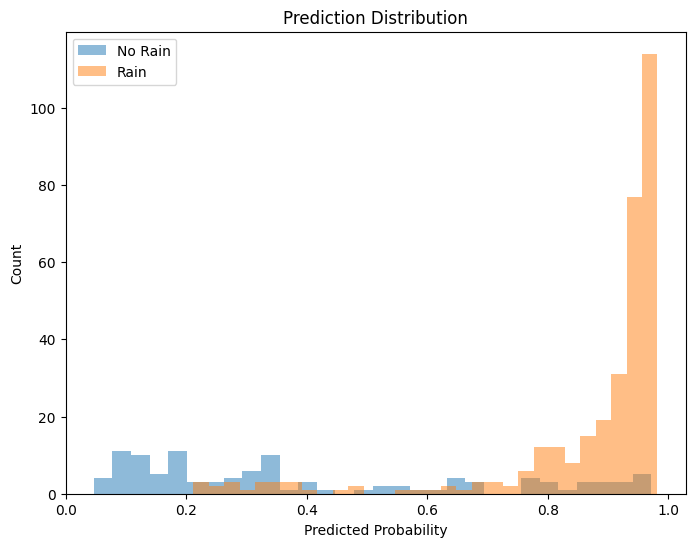

[[ 73  35]
 [ 22 308]]


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve

# Generate binary predictions (threshold at 0.5)
val_class = (val_preds > 0.5).astype(int)

# 1. Classification Report
print("Classification Report:")
print(classification_report(y_val, val_class))

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_val, val_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_val, val_preds):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, val_preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# 4. Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(val_preds[y_val==0], bins=30, alpha=0.5, label='No Rain')
plt.hist(val_preds[y_val==1], bins=30, alpha=0.5, label='Rain')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Prediction Distribution')
plt.legend()
plt.show()

# 5. Confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, val_class))